You can create a MLTable data asset when your data is stored in a folder together with a MLTable file. When you have created the data asset, you can specify it as input with the following code:

In [ ]:
from azure.ai.ml.constants import AssetTypes
from azure.ai.ml import Input

my_training_data_input = Input(type=AssetTypes.MLTABLE, path="azureml:input-data-automl:1")

When you use the Python SDK (v2) to configure an AutoML experiment or job, you configure the experiment using the automl class. For classification, you'll use the automl.classification function as shown in the following example:

In [ ]:
from azure.ai.ml import automl

# configure the classification job
classification_job = automl.classification(
    compute="aml-cluster",
    experiment_name="auto-ml-class-dev",
    training_data=my_training_data_input,
    target_column_name="Diabetic",
    primary_metric="accuracy",
    n_cross_validations=5,
    enable_model_explainability=True
)

AutoML needs a MLTable data asset as input. In the example, my_training_data_input refers to a MLTable data asset created in the Azure Machine Learning workspace.

You can submit an AutoML job with the following code

In [ ]:
# submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    classification_job
)

You can monitor AutoML job runs in the Azure Machine Learning studio. To get a direct link to the AutoML job by running the following code

In [ ]:
aml_url = returned_job.studio_url
print("Monitor your job at", aml_url)

In [ ]:
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azure.ai.ml import MLClient

try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

In [ ]:
# Get a handle to workspace
ml_client = MLClient.from_config(credential=credential)

In [ ]:
from azure.ai.ml.constants import AssetTypes
from azure.ai.ml import Input

# creates a dataset based on the files in the local data folder
my_training_data_input = Input(type=AssetTypes.MLTABLE, path="azureml:diabetes-training:1")

In [ ]:
from azure.ai.ml import automl

# configure the classification job
classification_job = automl.classification(
    compute="aml-cluster",
    experiment_name="auto-ml-class-dev",
    training_data=my_training_data_input,
    target_column_name="Diabetic",
    primary_metric="accuracy",
    n_cross_validations=5,
    enable_model_explainability=True
)

# set the limits (optional)
classification_job.set_limits(
    timeout_minutes=60, 
    trial_timeout_minutes=20, 
    max_trials=5,
    enable_early_termination=True,
)

# set the training properties (optional)
classification_job.set_training(
    blocked_training_algorithms=["LogisticRegression"], 
    enable_onnx_compatible_models=True
)

In [ ]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    classification_job
)  

# submit the job to the backend
aml_url = returned_job.studio_url
print("Monitor your job at", aml_url)

# Retrieve metrics with MLflow in a notebook

When you run a training script as a job in Azure Machine Learning, and track your model training with MLflow, you can query the runs in a notebook by using MLflow. Using MLflow in a notebook gives you more control over which runs you want to retrieve to compare.

When using MLflow to query your runs, you'll refer to experiments and runs.

In [ ]:
# Show all the experiments
experiments = mlflow.search_experiments(max_results=2)
for exp in experiments:
    print(exp.name)

In [ ]:
# To reach archived experiments
from mlflow.entities import ViewType

experiments = mlflow.search_experiments(view_type=ViewType.ALL)
for exp in experiments:
    print(exp.name)

In [ ]:
# To retrieve a specific experiment
exp = mlflow.get_experiment_by_name(experiment_name)
print(exp)

MLflow allows you to search for runs inside of any experiment. You need either the experiment ID or the experiment name.

In [ ]:
mlflow.search_runs(exp.experiment_id)

In [ ]:
# For example, if you want to sort by start time and only show the last two results:
mlflow.search_runs(exp.experiment_id, order_by=["start_time DESC"], max_results=2)

In [ ]:
# You can also look for a run with a specific combination in the hyperparameters:
mlflow.search_runs(
    exp.experiment_id, filter_string="params.num_boost_round='100'", max_results=2
)

Please visit for more: https://mlflow.org/docs/latest/search-runs.html

In [ ]:
# Defining a search space
from azure.ai.ml.sweep import Choice, Normal

command_job_for_sweep = job(
    batch_size=Choice(values=[16, 32, 64]),    
    learning_rate=Normal(mu=10, sigma=3),
)

In [ ]:
# Grid sampling
from azure.ai.ml.sweep import Choice

command_job_for_sweep = command_job(
    batch_size=Choice(values=[16, 32, 64]),
    learning_rate=Choice(values=[0.01, 0.1, 1.0]),
)

sweep_job = command_job_for_sweep.sweep(
    sampling_algorithm = "grid",
    ...
)

In [ ]:
# Randam sampling
from azure.ai.ml.sweep import Normal, Uniform

command_job_for_sweep = command_job(
    batch_size=Choice(values=[16, 32, 64]),   
    learning_rate=Normal(mu=10, sigma=3),
)

sweep_job = command_job_for_sweep.sweep(
    sampling_algorithm = "random",
    ...
)

In [ ]:
# Sobol
from azure.ai.ml.sweep import RandomParameterSampling

sweep_job = command_job_for_sweep.sweep(
    sampling_algorithm = RandomParameterSampling(seed=123, rule="sobol"),
    ...
)

In [ ]:
# Bayesian sampling
from azure.ai.ml.sweep import Uniform, Choice

command_job_for_sweep = job(
    batch_size=Choice(values=[16, 32, 64]),    
    learning_rate=Uniform(min_value=0.05, max_value=0.1),
)

sweep_job = command_job_for_sweep.sweep(
    sampling_algorithm = "bayesian",
    ...
)

# Early Termination Policies

## Bandit Policy

You can use a bandit policy to stop a trial if the target performance metric underperforms the best trial so far by a specified margin.

For example, the following code applies a bandit policy with a delay of five trials, evaluates the policy at every interval, and allows an absolute slack amount of 0.2.

In [ ]:
from azure.ai.ml.sweep import BanditPolicy

sweep_job.early_termination = BanditPolicy(
    slack_amount = 0.2, 
    delay_evaluation = 5, 
    evaluation_interval = 1
)

Imagine the primary metric is the accuracy of the model. When after the first five trials, the best performing model has an accuracy of 0.9, any new model needs to perform better than (0.9-0.2) or 0.7. If the new model's accuracy is higher than 0.7, the sweep job will continue. If the new model has an accuracy score lower than 0.7, the policy will terminate the sweep job.

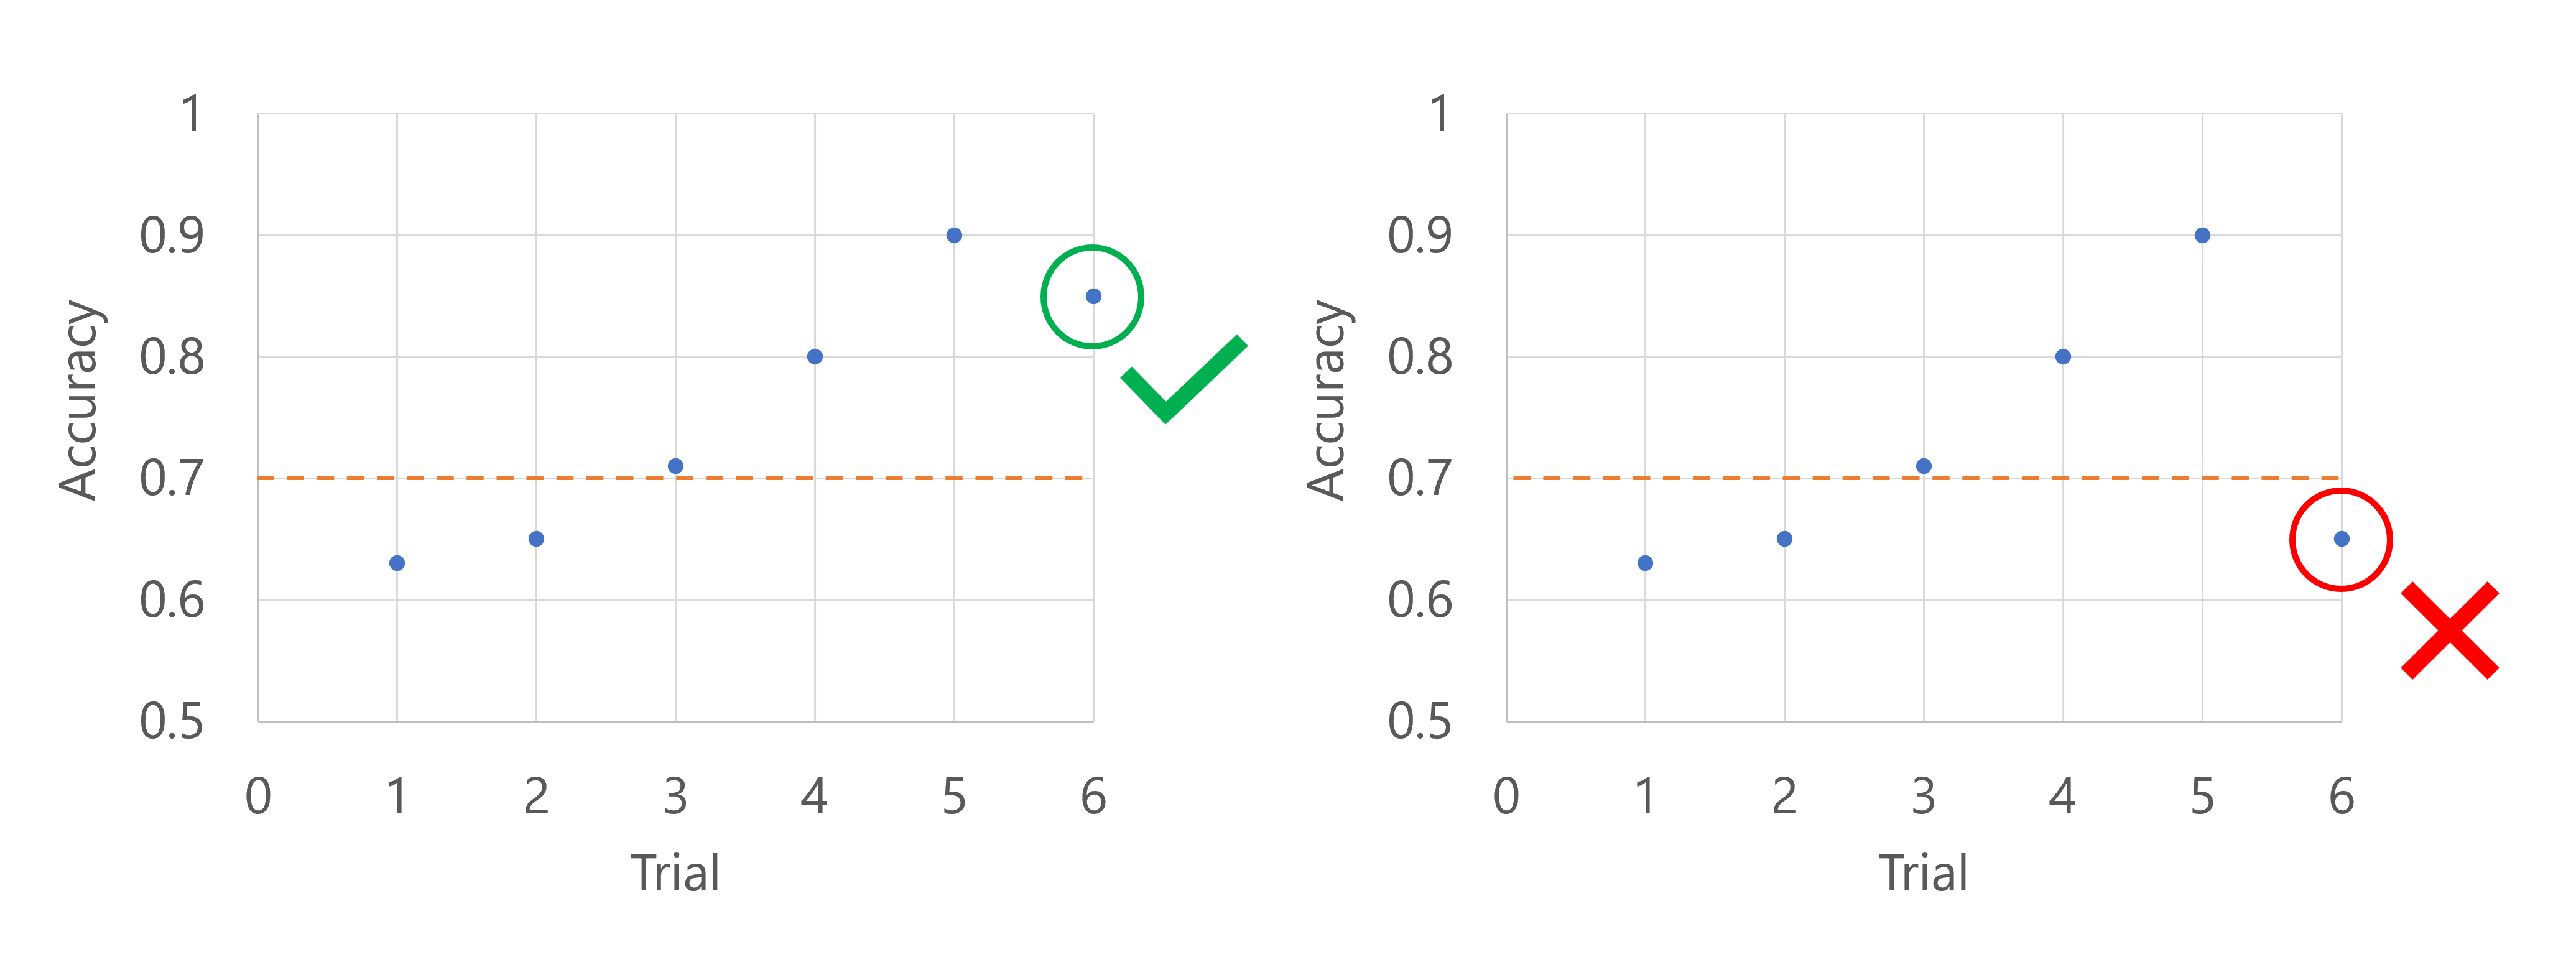

You can also apply a bandit policy using a slack factor, which compares the performance metric as a ratio rather than an absolute value.

## Median Stopping Policy

A median stopping policy abandons trials where the target performance metric is worse than the median of the running averages for all trials.

For example, the following code applies a median stopping policy with a delay of five trials and evaluates the policy at every interval.

In [ ]:
from azure.ai.ml.sweep import MedianStoppingPolicy

sweep_job.early_termination = MedianStoppingPolicy(
    delay_evaluation = 5, 
    evaluation_interval = 1
)

Imagine the primary metric is the accuracy of the model. When the accuracy is logged for the sixth trial, the metric needs to be higher than the median of the accuracy scores so far. Suppose the median of the accuracy scores so far is 0.82. If the new model's accuracy is higher than 0.82, the sweep job will continue. If the new model has an accuracy score lower than 0.82, the policy will stop the sweep job, and no new models will be trained.

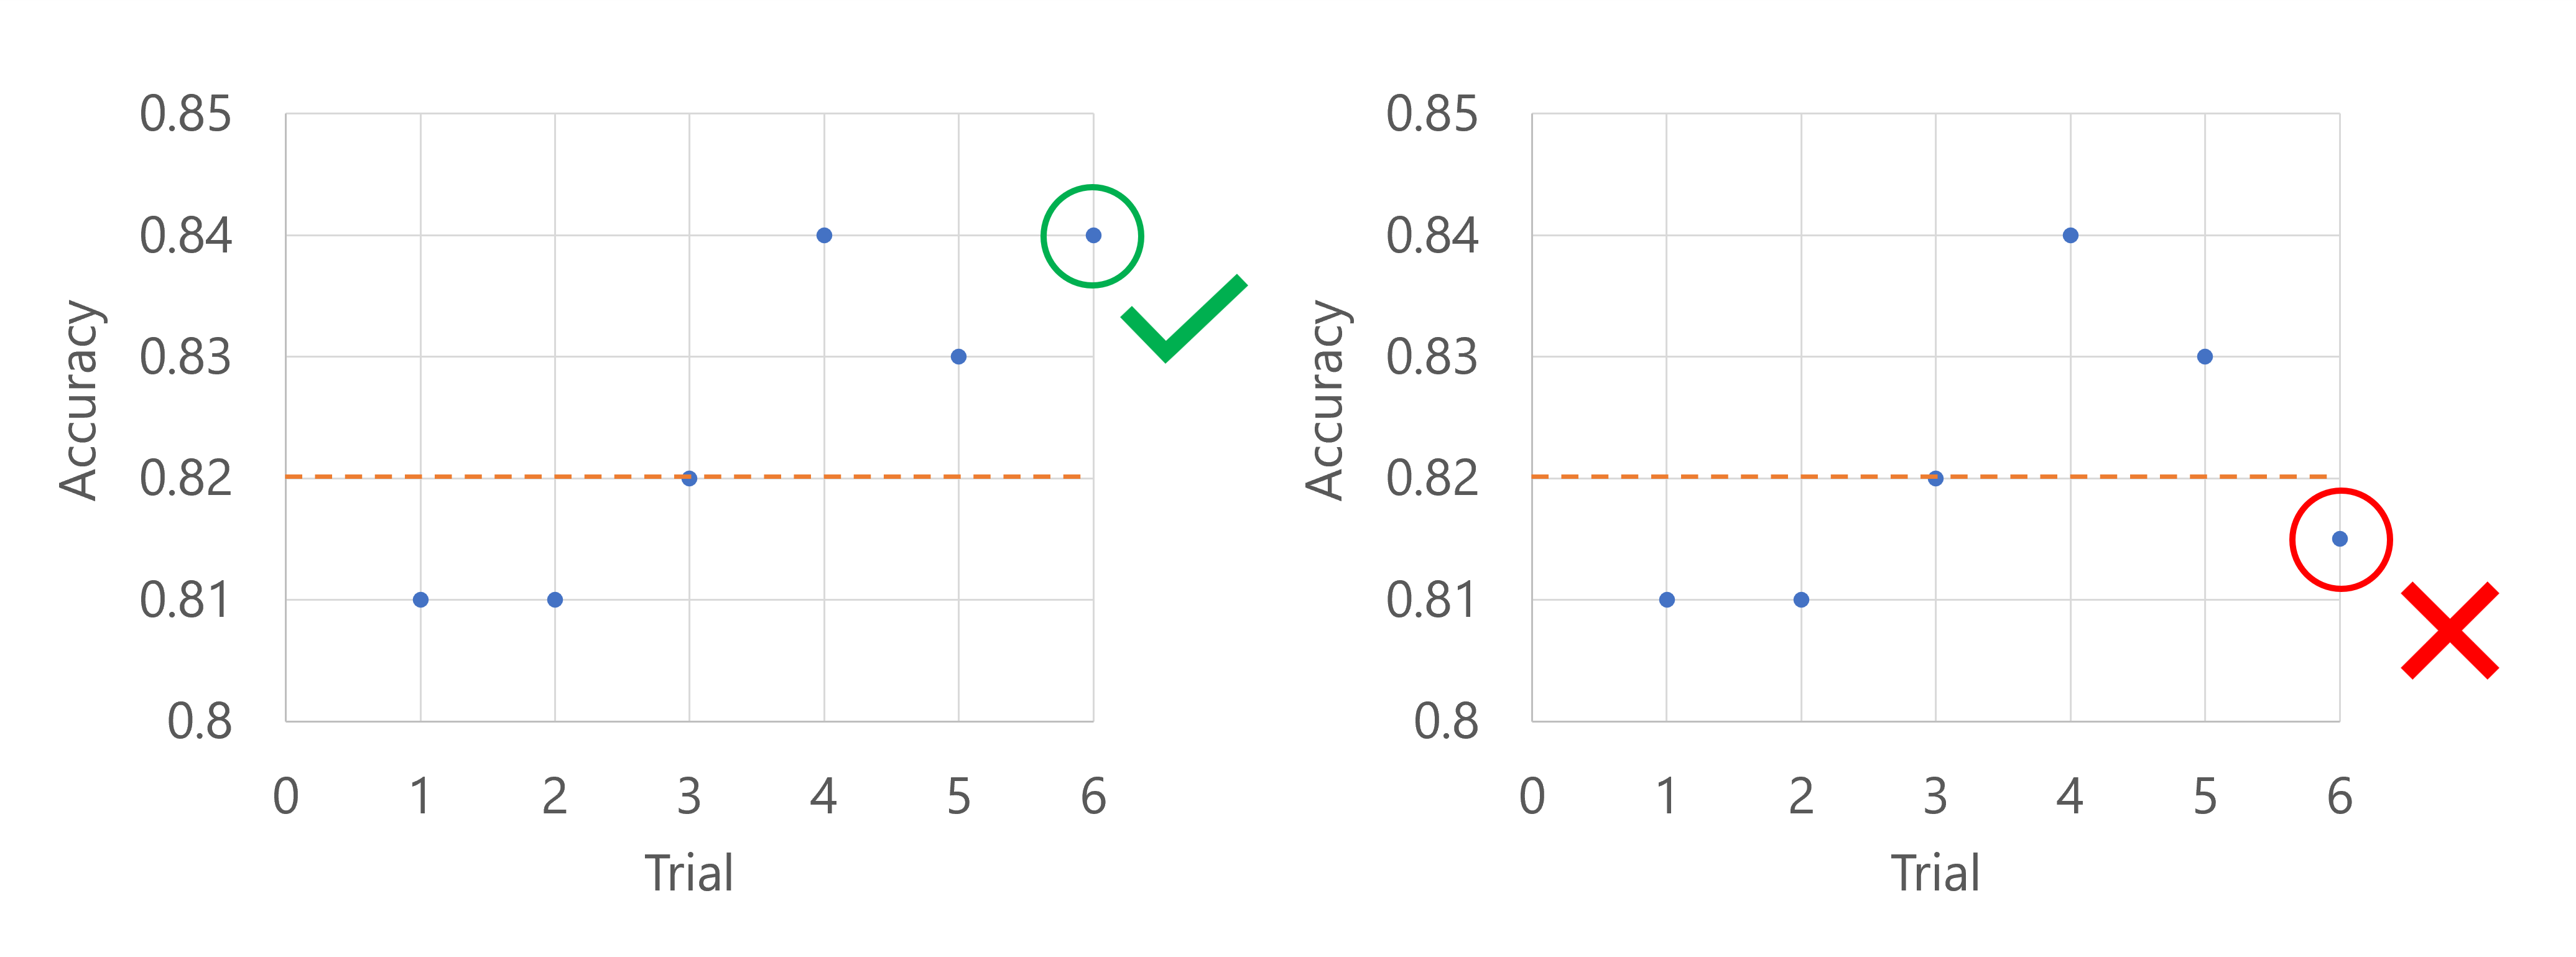

## Truncation Selection Policy

A truncation selection policy cancels the lowest performing X% of trials at each evaluation interval based on the truncation_percentage value you specify for X.

For example, the following code applies a truncation selection policy with a delay of four trials, evaluates the policy at every interval, and uses a truncation percentage of 20%.

In [ ]:
from azure.ai.ml.sweep import TruncationSelectionPolicy

sweep_job.early_termination = TruncationSelectionPolicy(
    evaluation_interval=1, 
    truncation_percentage=20, 
    delay_evaluation=4 
)

Imagine the primary metric is the accuracy of the model. When the accuracy is logged for the fifth trial, the metric should not be in the worst 20% of the trials so far. In this case, 20% translates to one trial. In other words, if the fifth trial is not the worst performing model so far, the sweep job will continue. If the fifth trial has the lowest accuracy score of all trials so far, the sweep job will stop.

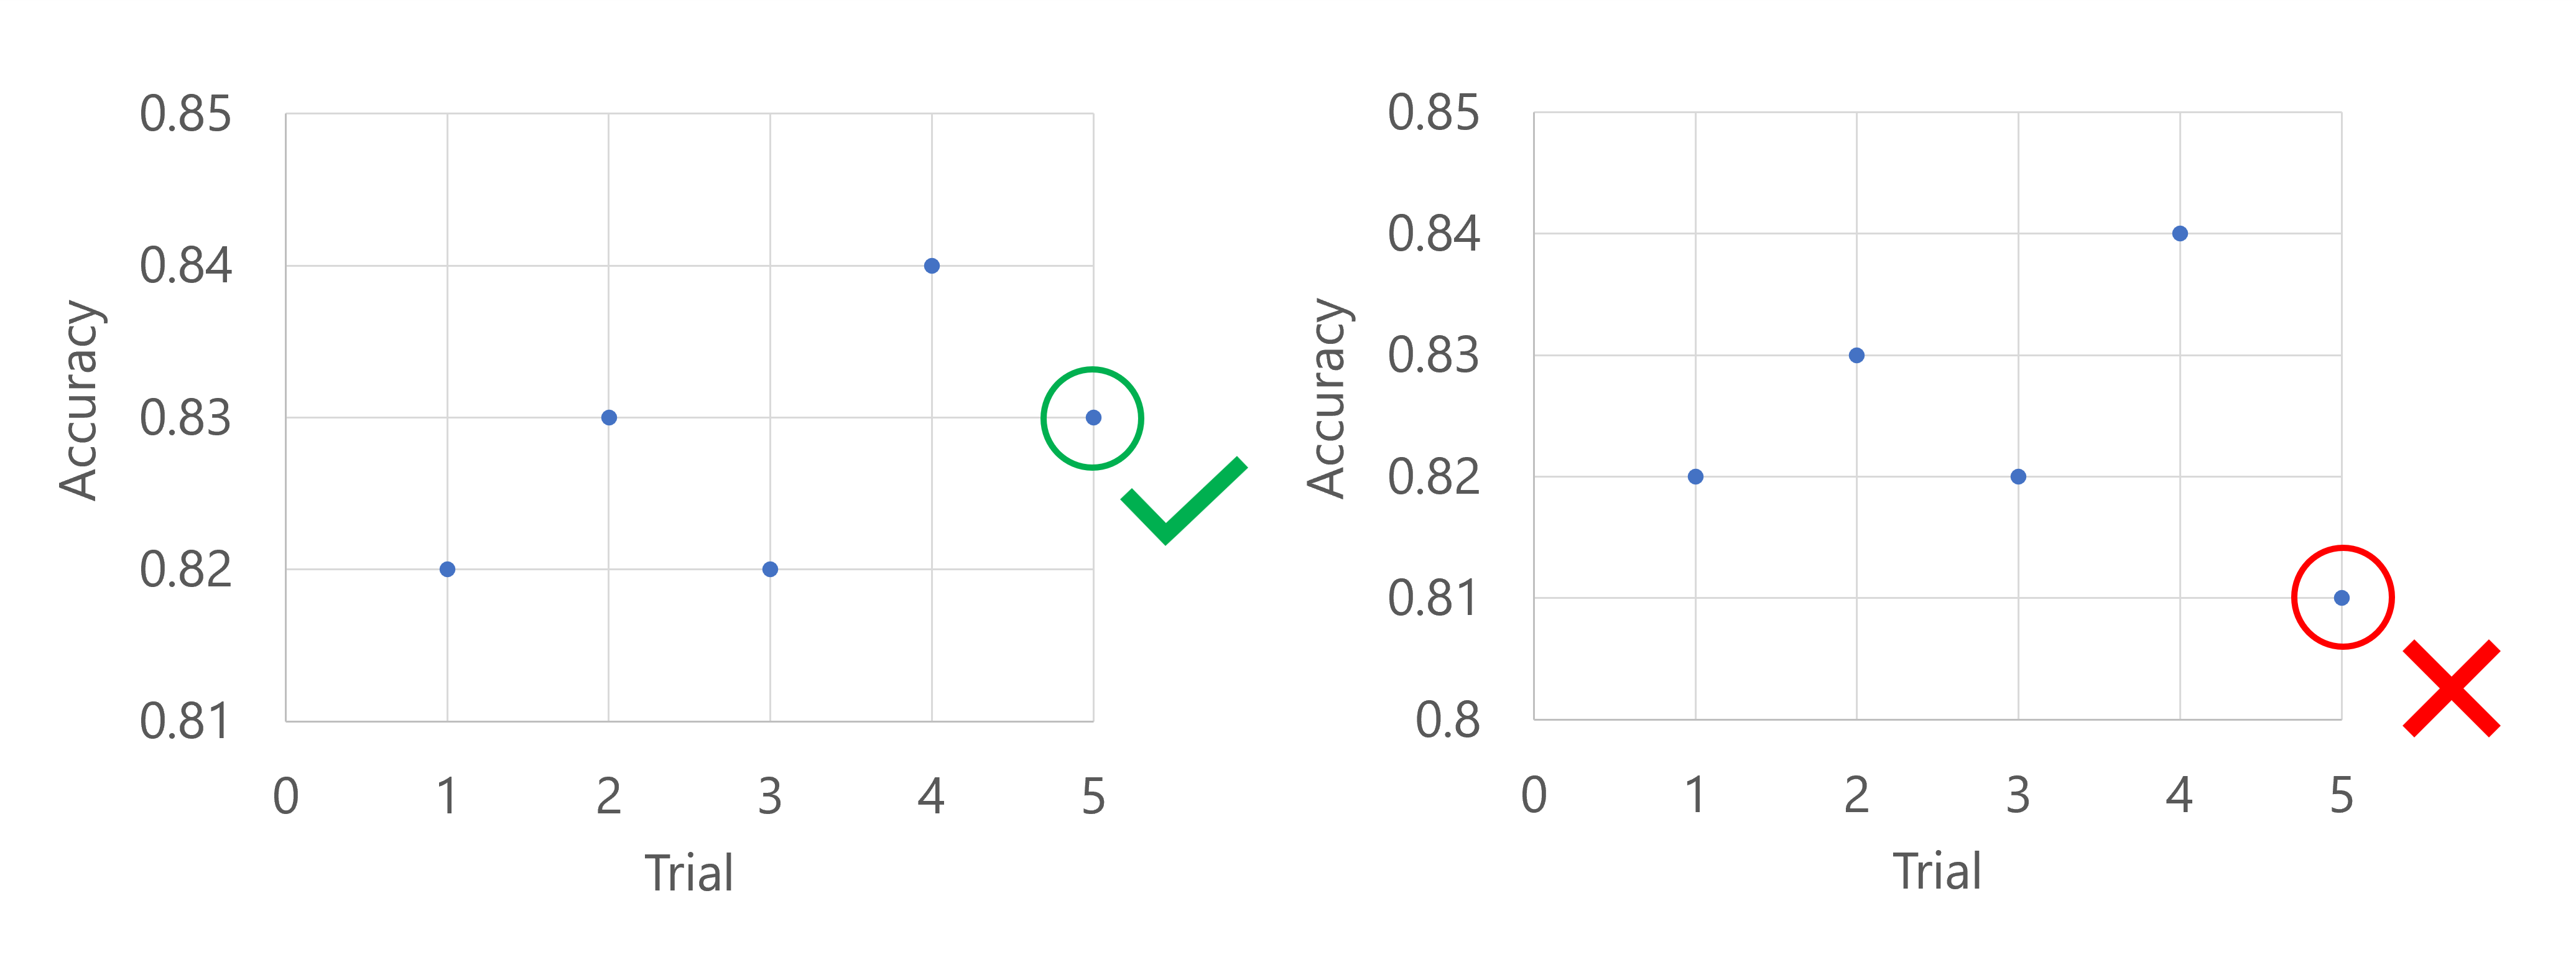